# DLAV Project - Phase 1

In this notebook we will train a very simple planner on data coming from a driving simulator. You are given a dash cam image of the current state of the driving vehicle, and the past positions of this vehicle, and you are asked to plan its future route.

This notebook will take you through steps on building this planner to solve the task. The full skeleton of the code together with some very simple implementations of each module are provided for your comfort. So all the cells below will run without you needing to change anything, but the performance won't be very good. You are asked to re-implement and play with most of the modules yourself to be able to have better performance.

P.S. to enable fast compute, you should use GPUs in google colab. The code works without GPUs, but it'll be much faster to use GPUs, specially if your model gets bigger and bigger! You can utilize Colab's GPUs by selecting "Change runtime type" in the Runtime menu on top of this page. There you can select "T4 GPU". This would restart your runtime, so you'll need to re-run everything from the top.

The first step is to prepare the data. The code below will download the data from google drive and extract it here for your code to use. Whenever your session gets restarted, remember to re-run this cell to re-download the data.

In [12]:
import gdown
import zipfile
import os

def folder_exists_and_not_empty(folder):
    return os.path.isdir(folder) and len(os.listdir(folder)) > 0

datasets = {
    "train": ("https://drive.google.com/uc?id=1YkGwaxBKNiYL2nq--cB6WMmYGzRmRKVr", "dlav_train.zip"),
    "val": ("https://drive.google.com/uc?id=1wtmT_vH9mMUNOwrNOMFP6WFw6e8rbOdu", "dlav_val.zip"),
    "test_public": ("https://drive.google.com/uc?id=1G9xGE7s-Ikvvc2-LZTUyuzhWAlNdLTLV", "dlav_test_public.zip"),
}

for folder, (url, zip_name) in datasets.items():
    if not folder_exists_and_not_empty(folder):
        print(f"Downloading and extracting {folder} dataset...")
        gdown.download(url, zip_name, quiet=False)
        with zipfile.ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall(".")
    else:
        print(f"{folder} folder already exists and is not empty. Skipping download.")


train folder already exists and is not empty. Skipping download.
val folder already exists and is not empty. Skipping download.
test_public folder already exists and is not empty. Skipping download.


Now lets load the data and visualize the first few examples to see what we are dealing with!

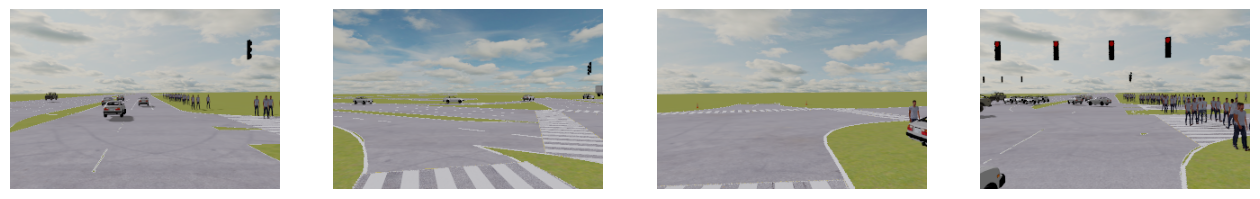

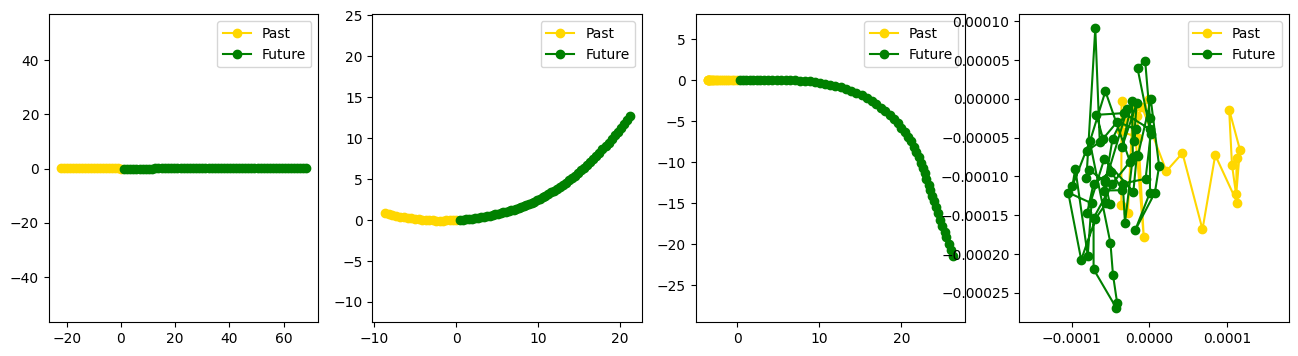

In [13]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random

k = 4
# load the data
data = []
for i in random.choices(np.arange(1000), k=k):
    with open(f"train/{i}.pkl", "rb") as f:
        data.append(pickle.load(f))

# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].imshow(data[i]["camera"])
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i in range(k):
    axis[i].plot(data[i]["sdc_history_feature"][:, 0], data[i]["sdc_history_feature"][:, 1], "o-", color="gold", label="Past")
    axis[i].plot(data[i]["sdc_future_feature"][:, 0], data[i]["sdc_future_feature"][:, 1], "o-", color="green", label="Future")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now its time to make our hands dirty!

In the following cells we will define the classes we need to do a proper training in pytorch.

1. We will start with defining a Dataset class which loads the data and does some basic preprocessing. You can further process this data as you see fit.
2. We then define the logger which receives training metrics and logs and prints/visualizes them. Having a good logger means a lot when dealing with neural network training! The logger implemented here is very simple and we strongly suggest you try other ways of visualizing your losses and metrics. Be creative ;)
3. We then proceed with defining the core part of the pipeline, the model. You are going to mainly implement the model yourself, but we have provided a very simple model so that the code runs as is so that you can see how the whole framework runs all in all.
4. Finally, we define the training funciton which contains the training loop, and we call it to see the magic! You'll need to also do a lot of changes here, from the batch size and learning rate, to adding augmentation schemes and schedulers, etc.

In [14]:
import torch
import os
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: NVIDIA GeForce RTX 4060 Ti


In [15]:
import torch
from torch.utils.data import Dataset
import pickle

class DrivingDataset(Dataset):
    def __init__(self, file_list, test=False):
        self.samples = file_list
        self.test = test

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        # Load pickle file
        with open(self.samples[idx], 'rb') as f:
            data = pickle.load(f)

        # Convert numpy arrays to tensors
        camera = torch.FloatTensor(data['camera']).permute(2, 0, 1)
        history = torch.FloatTensor(data['sdc_history_feature'])
        if not self.test:
          future = torch.FloatTensor(data['sdc_future_feature'])
          return {
            'camera': camera,
            'history': history,
            'future': future
          }
        else:
          return {
            'camera': camera,
            'history': history
          }


In [16]:
import matplotlib.pyplot as plt

class Logger:
    def __init__(self):
        # will hold per-epoch losses
        self.history = {'train_loss': [], 'val_loss': []}

    def log_epoch(self, epoch, train_loss, val_loss, **metrics):
        """
        Call once per epoch.
        """
        # store
        self.history['train_loss'].append(train_loss)
        self.history['val_loss'].append(val_loss)

        # print summary
        metric_str = " | ".join(f"{k}: {v:.4f}" for k,v in metrics.items())
        print(f"[Epoch {epoch+1}] Train: {train_loss:.4f} | Val: {val_loss:.4f}"
              + (f" | {metric_str}" if metric_str else "") )

    def plot(self):
        """
        Call after training to visualize the curves.
        """
        epochs = range(1, len(self.history['train_loss'])+1)
        plt.figure(figsize=(6,4))
        plt.plot(epochs, self.history['train_loss'], label='Train Loss')
        plt.plot(epochs, self.history['val_loss'],   label='Val   Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss vs. Epoch')
        plt.legend()
        plt.tight_layout()
        plt.show()


In [17]:
import torch
import torch.nn as nn

class HistoryRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.rnn = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, history):
        # history: [B, 21, 3] (batch_size, seq_len=21, feature_dim=3)
        _, (hidden_state, _) = self.rnn(history)

        hidden_state = hidden_state[-1]

        hidden_state = self.layer_norm(hidden_state)

        return hidden_state


In [18]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=3):
        super().__init__()

        # input size: 3x300x200
        self.features = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, 3, padding=1),  # 32x300x200
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32x16x16

            nn.Conv2d(32, 64, 3, padding=1),  # 64x16x16
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64x8x8

            nn.Conv2d(64, 128, 3, padding=1),  # 128x8x8
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128x4x4

            nn.Conv2d(128, 256, 3, padding=1),  # 256x4x4
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 256x2x2

            nn.Conv2d(256, 512, 3, padding=1),  # 512x2x2
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )

        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):

        x = self.features(x)
        x = self.global_pool(x)
        x = self.flatten(x)
        x = self.dropout(x)

        return x

In [19]:
class DrivingPlanner(nn.Module):
    def __init__(self,num_channels=3, history_dim=256):
        super().__init__()

        self.cnn = ConvNet(n_input_channels=num_channels)

        self.rnn_history = HistoryRNN(input_dim=3, hidden_dim=history_dim)

        cnn_embed_dim = 512
        history_feature_dim = history_dim

        # Total input dimension for the decoder layer (ViT output + history output)
        decoder_input_dim = cnn_embed_dim + history_feature_dim

        # Enhanced Decoder
        self.decoder = nn.Sequential(
            nn.Linear(decoder_input_dim, 1024),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 512),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(512, 60*3)
        )

        self.residual = nn.Linear(decoder_input_dim, 60*3)

    def forward(self, camera, history):
        # Process camera images using Vision Transformer
        visual_features = self.cnn(camera)

        history_features = self.rnn_history(history)

        combined_features = torch.cat([visual_features, history_features], dim=1)

        x = self.decoder(combined_features)
        x = self.residual(combined_features) + x
        x = x.reshape(-1, 60, 3)  # Reshaping to (batch_size, timesteps, features)

        return x


In [20]:
import tqdm

def train(model, train_loader, val_loader, optimizer,scheduler, logger, num_epochs=50):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    print(f'using {device}')

    criterion = nn.SmoothL1Loss()

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)
        for idx, batch in enumerate(pbar):
            camera = batch['camera'].to(device)
            history = batch['history'].to(device)
            future = batch['future'].to(device)
            assert camera.device.type == 'cuda', "Camera is not on GPU!"
            assert history.device.type == 'cuda', "History is not on GPU!"
            assert future.device.type == 'cuda', "Future is not on GPU!"
            assert next(model.parameters()).is_cuda, "Model is not on GPU!"

            optimizer.zero_grad()
            pred_future = model(camera, history)
            position_loss = criterion(pred_future[..., :2], future[..., :2])
            control_loss = torch.mean(1 - torch.cos(pred_future[..., 2] - future[..., 2]))
            loss = position_loss + 0.4*control_loss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train = train_loss / len(train_loader)

        # Validation
        model.eval()
        val_loss, ade_all, fde_all = 0, [], []
        with torch.no_grad():
            for batch in val_loader:
                camera = batch['camera'].to(device)
                history = batch['history'].to(device)
                future = batch['future'].to(device)

                pred_future = model(camera, history)
                loss = criterion(pred_future, future)
                ADE = torch.norm(pred_future[:, :, :2] - future[:, :, :2], p=2, dim=-1).mean()
                FDE = torch.norm(pred_future[:, -1, :2] - future[:, -1, :2], p=2, dim=-1).mean()
                ade_all.append(ADE.item())
                fde_all.append(FDE.item())
                val_loss += loss.item()

        avg_val = val_loss   / len(val_loader)
        avg_ADE, avg_FDE = sum(ade_all)/len(ade_all), sum(fde_all)/len(fde_all)

        logger.log_epoch(epoch, avg_train, avg_val, ADE=avg_ADE, FDE=avg_FDE)
        scheduler.step(avg_val)

    logger.plot()


using cuda


[Epoch 1] Train: 2.8529 | Val: 1.2165 | ADE: 3.5753 | FDE: 9.1158


[Epoch 2] Train: 1.7788 | Val: 1.1880 | ADE: 3.6033 | FDE: 8.7115


[Epoch 3] Train: 1.5898 | Val: 0.9364 | ADE: 2.8862 | FDE: 7.6234


[Epoch 4] Train: 1.3645 | Val: 0.9091 | ADE: 2.7278 | FDE: 7.3584


[Epoch 5] Train: 1.2917 | Val: 0.8834 | ADE: 2.6746 | FDE: 7.0690


[Epoch 6] Train: 1.2792 | Val: 1.0516 | ADE: 3.1874 | FDE: 8.0773


[Epoch 7] Train: 1.2112 | Val: 0.7479 | ADE: 2.3174 | FDE: 6.4395


[Epoch 8] Train: 1.1345 | Val: 0.7912 | ADE: 2.4073 | FDE: 6.6422


[Epoch 9] Train: 1.1091 | Val: 0.7240 | ADE: 2.2328 | FDE: 6.2062


[Epoch 10] Train: 1.0785 | Val: 0.7853 | ADE: 2.4434 | FDE: 6.5914


[Epoch 11] Train: 1.0453 | Val: 0.9105 | ADE: 2.7966 | FDE: 7.2226


[Epoch 12] Train: 1.0183 | Val: 0.6961 | ADE: 2.1633 | FDE: 5.9472


[Epoch 13] Train: 0.9949 | Val: 0.7757 | ADE: 2.3438 | FDE: 6.4270


[Epoch 14] Train: 1.0055 | Val: 0.7085 | ADE: 2.2154 | FDE: 6.0203


[Epoch 15] Train: 0.9520 | Val: 1.1351 | ADE: 3.4459 | FDE: 8.4507


[Epoch 16] Train: 0.9418 | Val: 0.6641 | ADE: 2.0733 | FDE: 5.6473


[Epoch 17] Train: 0.9104 | Val: 0.7939 | ADE: 2.4276 | FDE: 6.4933


[Epoch 18] Train: 0.8670 | Val: 0.7030 | ADE: 2.2132 | FDE: 5.9302


[Epoch 19] Train: 0.8597 | Val: 0.6714 | ADE: 2.0940 | FDE: 5.8014


[Epoch 20] Train: 0.8216 | Val: 0.6680 | ADE: 2.0633 | FDE: 5.6936


[Epoch 21] Train: 0.8032 | Val: 0.8599 | ADE: 2.6827 | FDE: 7.2266


[Epoch 22] Train: 0.8228 | Val: 0.8782 | ADE: 2.6841 | FDE: 7.6989


[Epoch 23] Train: 0.6982 | Val: 0.5787 | ADE: 1.8675 | FDE: 5.2472


[Epoch 24] Train: 0.6676 | Val: 0.6270 | ADE: 1.9672 | FDE: 5.4260


[Epoch 25] Train: 0.6453 | Val: 0.7007 | ADE: 2.2380 | FDE: 5.8869


[Epoch 26] Train: 0.6771 | Val: 0.7100 | ADE: 2.2075 | FDE: 6.2285


[Epoch 27] Train: 0.6052 | Val: 0.6068 | ADE: 1.9180 | FDE: 5.4534


[Epoch 28] Train: 0.5956 | Val: 0.6348 | ADE: 2.0253 | FDE: 5.4997


[Epoch 29] Train: 0.5875 | Val: 0.5837 | ADE: 1.8631 | FDE: 5.3036


[Epoch 30] Train: 0.5051 | Val: 0.5576 | ADE: 1.7901 | FDE: 5.0997


[Epoch 31] Train: 0.4863 | Val: 0.5576 | ADE: 1.7852 | FDE: 5.0711


[Epoch 32] Train: 0.4647 | Val: 0.5732 | ADE: 1.8297 | FDE: 5.1662


[Epoch 33] Train: 0.4558 | Val: 0.5562 | ADE: 1.7770 | FDE: 5.0469


[Epoch 34] Train: 0.4376 | Val: 0.5628 | ADE: 1.8133 | FDE: 5.1016


[Epoch 35] Train: 0.4478 | Val: 0.5720 | ADE: 1.8288 | FDE: 5.1493


[Epoch 36] Train: 0.4281 | Val: 0.5487 | ADE: 1.7687 | FDE: 5.0272


[Epoch 37] Train: 0.4110 | Val: 0.6103 | ADE: 1.9414 | FDE: 5.4213


[Epoch 38] Train: 0.4055 | Val: 0.5700 | ADE: 1.8109 | FDE: 5.1404


[Epoch 39] Train: 0.3783 | Val: 0.5625 | ADE: 1.8004 | FDE: 5.1212


[Epoch 40] Train: 0.3893 | Val: 0.5542 | ADE: 1.7882 | FDE: 5.0192


[Epoch 41] Train: 0.3924 | Val: 0.5476 | ADE: 1.7633 | FDE: 5.0021


[Epoch 42] Train: 0.3759 | Val: 0.5533 | ADE: 1.7777 | FDE: 5.0173


[Epoch 43] Train: 0.3614 | Val: 0.5571 | ADE: 1.7916 | FDE: 5.0865


[Epoch 44] Train: 0.3511 | Val: 0.5554 | ADE: 1.7759 | FDE: 5.0221


[Epoch 45] Train: 0.3450 | Val: 0.6023 | ADE: 1.9272 | FDE: 5.4846


[Epoch 46] Train: 0.3456 | Val: 0.5986 | ADE: 1.9057 | FDE: 5.3459


[Epoch 47] Train: 0.3329 | Val: 0.5691 | ADE: 1.8204 | FDE: 5.1206


[Epoch 48] Train: 0.2988 | Val: 0.5430 | ADE: 1.7408 | FDE: 4.9634


[Epoch 49] Train: 0.2923 | Val: 0.5499 | ADE: 1.7739 | FDE: 4.9969


[Epoch 50] Train: 0.2784 | Val: 0.5552 | ADE: 1.7850 | FDE: 5.0284


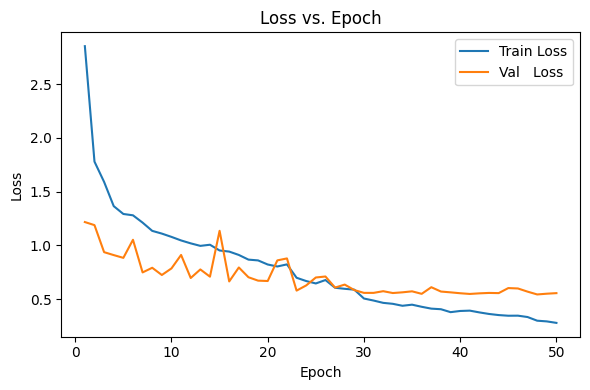

In [21]:
import torch.optim as optim
from torch.utils.data import DataLoader
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau

train_data_dir = "train"
val_data_dir = "val"

train_files = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith('.pkl')]
val_files = [os.path.join(val_data_dir, f) for f in os.listdir(val_data_dir) if f.endswith('.pkl')]

train_dataset = DrivingDataset(train_files)
val_dataset = DrivingDataset(val_files)

train_loader = DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=0, pin_memory=True)

model = DrivingPlanner(
    num_channels=3,
    history_dim=256
)

optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.001)

# ReduceLROnPlateau: reduces LR when validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

logger = Logger()

train(model, train_loader, val_loader, optimizer,scheduler, logger, num_epochs=50)


By running the code above, you have trained your first model!
What do you observe in terms of train and val losses? What is this phenomenon called? (Explain in a few lines below)




This model is very simple and does not necessarilly yield the optimal performance. You are asked to implement your own neural network architecture. You can use convolution networks, vision transformers, etc. Try with different architectures, different model sizes, and other hyper parameters such as learning rate and batch size to find the best performance. Other ideas could be to use augmentation thechniques to boost the performance, adding learning rate schedulers, and exploring other loss functions.

Once you are happy with your model, continue with the rest of the notebook to save your checkpoint and also visualize some plans coming from the model. The last cell will provide a `submission_phase1.csv` which you can submit to the leaderboard to see your results on the testing set.

In [22]:
# save the model
torch.save(model.state_dict(), "phase1_model.pth")

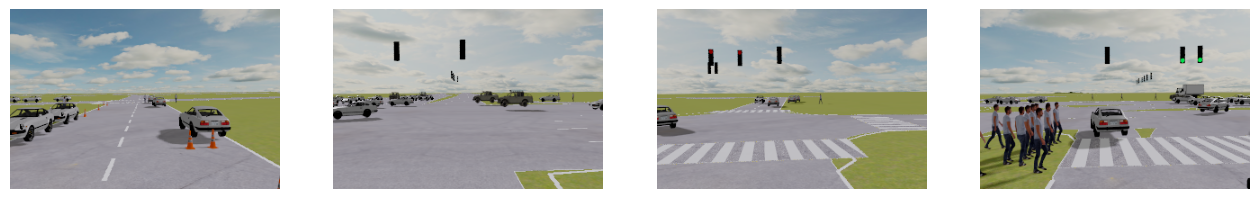

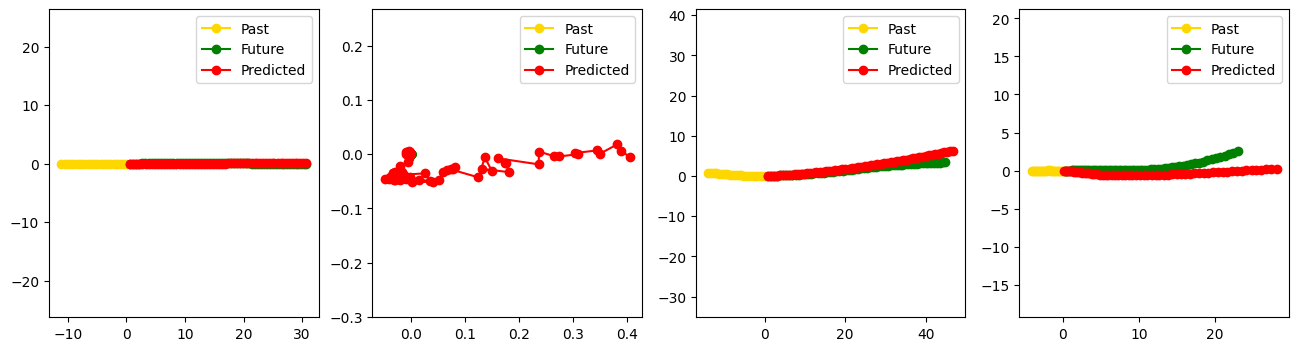

In [30]:
val_batch_zero = next(iter(val_loader))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
camera = val_batch_zero['camera'].to(device)
history = val_batch_zero['history'].to(device)
future = val_batch_zero['future'].to(device)

model.eval()
with torch.no_grad():
    pred_future = model(camera, history)

camera = camera.cpu().numpy()
history = history.cpu().numpy()
future = future.cpu().numpy()
pred_future = pred_future.cpu().numpy()
k=4
selected_indices = random.choices(np.arange(len(camera)), k=k)
# plot the camera view of current step for the k examples
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].imshow(camera[idx].transpose(1, 2, 0)/255)
    axis[i].axis("off")
plt.show()

# plot the past and future trajectory of the vehicle
fig, axis = plt.subplots(1, k, figsize=(4*k, 4))
for i, idx in enumerate(selected_indices):
    axis[i].plot(history[idx, :, 0], history[idx, :, 1], "o-", color="gold", label="Past")
    axis[i].plot(future[idx, :, 0], future[idx, :, 1], "o-", color="green", label="Future")
    axis[i].plot(pred_future[idx, :, 0], pred_future[idx, :, 1], "o-", color="red", label="Predicted")
    axis[i].legend()
    axis[i].axis("equal")
plt.show()

Now we run our model on the test set once, to get the plan of our model and save it for submission. Notice that the ground truth plans are removed for the test set, so you can not calculate the ADE metric on the test set yourself, and need to submit it to the leader board. By running the last cell, you'll be able to see a csv file called `submission_phase1.csv` by clicking on the folder icon on the left. Download it and submit it to the leaderboard to get your score.

In [24]:
with open(f"test_public/0.pkl", "rb") as f:
    data = pickle.load(f)
print(data.keys())
# Note the absence of sdc_future_feature

dict_keys(['camera', 'depth', 'driving_command', 'sdc_history_feature', 'semantic_label'])


In [25]:
import pandas as pd
test_data_dir = "test_public"
test_files = [os.path.join(test_data_dir, fn) for fn in sorted([f for f in os.listdir(test_data_dir) if f.endswith(".pkl")], key=lambda fn: int(os.path.splitext(fn)[0]))]

test_dataset = DrivingDataset(test_files, test=True)
test_loader = DataLoader(test_dataset, batch_size=250, num_workers=0)
model.eval()
all_plans = []
with torch.no_grad():
    for batch in test_loader:
        camera = batch['camera'].to(device)
        history = batch['history'].to(device)

        pred_future = model(camera, history)
        all_plans.append(pred_future.cpu().numpy()[..., :2])
all_plans = np.concatenate(all_plans, axis=0)

# Now save the plans as a csv file
pred_xy = all_plans[..., :2]  # shape: (total_samples, T, 2)

# Flatten to (total_samples, T*2)
total_samples, T, D = pred_xy.shape
pred_xy_flat = pred_xy.reshape(total_samples, T * D)

# Build a DataFrame with an ID column
ids = np.arange(total_samples)
df_xy = pd.DataFrame(pred_xy_flat)
df_xy.insert(0, "id", ids)

# Column names: id, x_1, y_1, x_2, y_2, ..., x_T, y_T
new_col_names = ["id"]
for t in range(1, T + 1):
    new_col_names.append(f"x_{t}")
    new_col_names.append(f"y_{t}")
df_xy.columns = new_col_names

# Save to CSV
df_xy.to_csv("submission_phase1.csv", index=False)

print(f"Shape of df_xy: {df_xy.shape}")

Shape of df_xy: (1000, 121)
